<a href="https://colab.research.google.com/github/surajsrivathsa/image_registration/blob/main/FIRE_suraj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference Paper -

https://arxiv.org/pdf/1907.05062.pdf

In [ ]:
!pip install SimpleITK

     |████████████████████████████████| 47.4MB 61kB/s 


In [ ]:
import os as os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
# !pip install --upgrade nibabel
import nibabel as nb
import os, sys, glob
import SimpleITK as sitk
print()

1.8.0+cu101
0.9.0+cu101



In [ ]:
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/"
data_path_t2 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/"
#data_path_t1 = "/content/drive/My Drive/Colab Notebooks/ImageRegistrationUsingDeepLearning/FIRE/Dataset/T1_resampled/"
#data_path_t2 = "/content/drive/My Drive/Colab Notebooks/ImageRegistrationUsingDeepLearning/FIRE/Dataset/T2_resampled/"
file_names_t1 = sorted(glob.glob(os.path.join(data_path_t1, "*.nii.gz")))
file_names_t2 = sorted(glob.glob(os.path.join(data_path_t2, "*.nii.gz")))

In [ ]:
img_nb1 = nb.load(file_names_t1[0])
print(img_nb1.shape)
img_nb2 = nb.load(file_names_t2[0])
print(img_nb2.shape)

(91, 109, 91)
(91, 109, 91)


In [ ]:
del img_nb1, img_nb2

In [ ]:
def load_4D(name):
        resamplng_shape = (128, 128, 128)
        X_nb = nb.load(name)
        X_np = X_nb.dataobj
       
        min_pixel_value = np.min(X_np)   # getting minimum pixel value which is -1 in my case.
        model_np = np.full(shape=(128, 128, 128),fill_value=min_pixel_value)
        x_dim, y_dim, z_dim = X_np.shape
        x_ltail = (resamplng_shape[0] - x_dim)//2 
        y_ltail = (resamplng_shape[1] - y_dim)//2
        z_ltail = (resamplng_shape[2] - z_dim)//2

        x_rtail = resamplng_shape[0] - x_ltail - 1
        y_rtail = resamplng_shape[1] - y_ltail - 1
        z_rtail = resamplng_shape[2] - z_ltail - 1
        model_np[x_ltail:x_rtail, y_ltail:y_rtail, z_ltail:z_rtail] = X_np[:, :, :]
        model_np = np.reshape(model_np, (1,)+ model_np.shape)
        return model_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2

def Norm_Zscore(img):
    img= (img-np.mean(img))/np.std(img) 
    return img

def save_img(I_img,savename):
    I2 = sitk.GetImageFromArray(I_img,isVector=False)
    sitk.WriteImage(I2,savename)

In [ ]:
class Dataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, names_t1,names_t2,iterations =1,norm=True):
        'Initialization'
        self.names_t1 = names_t1
        self.names_t2 = names_t2
        self.norm = norm
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.names_t1) * self.iterations

  def __getitem__(self, step):
        'Generates one sample of data'
        # index_pair = np.random.permutation(len(self.names)) [0:4]
        img_A = load_4D(self.names_t1[step])
        img_B = load_4D(self.names_t2[step])     
        
        if self.norm:
            # return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
            return  imgnorm(img_A) , imgnorm(img_B)
        else:
            return img_A, img_B


In [ ]:
training_generator = Data.DataLoader(Dataset(file_names_t1,file_names_t2,True), batch_size=2,shuffle=False)

In [ ]:
for  X,Y in training_generator:
  print(torch.max(X))
  print(torch.min(Y))
  print(X.shape)
  print(Y.shape)
  break

tensor(1.)
tensor(0.)
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])


In [ ]:
# sitk_t1 = sitk.ReadImage(file_names_t1[0])
# print(sitk_t1.GetSize())
print(load_4D(file_names_t1[0]).shape)
print(load_4D(file_names_t2[0]).shape)

(1, 128, 128, 128)
(1, 128, 128, 128)


### residual block

In [ ]:
def conv3x3x3(in_channels, out_channels, stride=1):
    return nn.Conv3d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
ResidualBlock(in_channels = 2, out_channels = 512)

ResidualBlock(
  (conv1): Conv3d(2, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (bn1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (bn2): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### encoder

In [ ]:
class Fire_Encoder(nn.Module):
    def __init__(self, in_channel, start_channel):
        self.in_channel = in_channel
        self.start_channel = start_channel
        super(Fire_Encoder, self).__init__()
        self.encoder0 = self.encoder(self.in_channel, self.start_channel, bias=True)
       
        self.encoder1 = self.encoder(self.start_channel, self.start_channel*2, stride=2, bias=True)

        self.encoder2 = self.encoder(self.start_channel*2, self.start_channel*4, stride=2, bias=True)

        self.residual_block1 = ResidualBlock(self.start_channel*4, self.start_channel*4)

        self.residual_block2 = ResidualBlock(self.start_channel*4, self.start_channel*4)

        self.residual_block3 = ResidualBlock(self.start_channel*4, self.start_channel*4)

        self.residual_block4 = ResidualBlock(self.start_channel*4, self.start_channel*4)

    def encoder(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=True ):
      layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias ),
                            nn.InstanceNorm3d(out_channels),
                            nn.LeakyReLU())
      layer.to("cuda")
      return layer
  
    def forward(self, x):
      e0 = self.encoder0(x)
      e1 = self.encoder1(e0)
      e2 = self.encoder2(e1)
      e3 = self.residual_block1(e2)
      e4 = self.residual_block1(e3)
      e5 = self.residual_block1(e4)
      e6 = self.residual_block1(e5)

      return e6

In [ ]:
encoder = Fire_Encoder(in_channel=1, start_channel=16).to("cuda")


In [ ]:
encoder

Fire_Encoder(
  (encoder0): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (encoder1): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (encoder2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (residual_block1): ResidualBlock(
    (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU

In [ ]:
for X,Y in training_generator:
  X = X.cuda().float()
  # Y = Y.cuda().float()
  print(X.shape)
  # print(Y.shape)
  encoder_output = encoder(X)
  print(encoder_output.shape)
  break

torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 64, 32, 32, 32])


In [ ]:
tnsr = torch.randn((2, 64, 32, 32, 32))

### Decoder

In [ ]:
class Synthesizer_Decoder(nn.Module):
  def __init__(self,start_channel):
        # self.in_channel = in_channel
        self.start_channel = start_channel

        ## Declarations #####      
        super(Synthesizer_Decoder, self).__init__()
        self.rb1 = ResidualBlock(self.start_channel*4, self.start_channel*4, 1)
        self.rb2 = ResidualBlock(self.start_channel*4, self.start_channel*4, 1)
        self.rb3 = ResidualBlock(self.start_channel*4, self.start_channel*4, 1)
        self.rb4 = ResidualBlock(self.start_channel*4, self.start_channel*4, 1)

        self.up1 = self.decoder(self.start_channel*4, self.start_channel*2)
        self.up2 = self.decoder(self.start_channel*2, self.start_channel*1)


        self.cb = self.convblock(self.start_channel*1, self.start_channel//2)
        self.out = self.onecrossoneblock(self.start_channel//2, 1)
        return;

  ### Decoder upsampler block start #####
  def decoder(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0,
                output_padding=0, bias=True):
    layer = nn.Sequential(
                nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride=stride,
                               padding=padding, output_padding=output_padding, bias=bias),
                                nn.LeakyReLU())
    return layer

  def convblock(self, in_channels, out_channels, kernel_size=3, 
                bias=False, batchnorm=False):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=0),)
    return layer
       
  def onecrossoneblock(self, in_channels, out_channels=1, kernel_size=1, 
                bias=False, batchnorm=False):
    layer = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=1),
               )
    return layer

  def forward(self, x):
        rout = self.rb1(x) 
        rout = self.rb2(rout)
        rout = self.rb3(rout)
        rout = self.rb4(rout) 
        dec1 = self.up1(rout)
        dec2 = self.up2(dec1)

        cbo = self.cb(dec2)
        output = self.out(cbo)
        return output

In [ ]:
decoder_fixed = Synthesizer_Decoder(start_channel=16).to("cuda")
decoder_moving = Synthesizer_Decoder(start_channel=16).to("cuda")

In [ ]:
for X,Y in training_generator:
  X = X.cuda().float()
  Y = Y.cuda().float()
  # print(X.shape)
  # print(Y.shape)
  encoder_output1 = encoder(X) 
  encoder_output2 = encoder(Y)
  print(encoder_output1.shape)
  print(encoder_output2.shape)
  decoder_output_fixed = decoder_fixed(encoder_output1)
  decoder_output_moving = decoder_moving(encoder_output2)
  print(decoder_output_fixed.shape)
  print(decoder_output_moving.shape)
  break

torch.Size([2, 64, 32, 32, 32])
torch.Size([2, 64, 32, 32, 32])
torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 1, 128, 128, 128])


# Transformer

### downsampler 

In [ ]:
class down_sampler(nn.Module):
    def __init__(self, in_channel, start_channel):
        self.in_channel = in_channel
        self.start_channel = start_channel
        super(down_sampler, self).__init__()
        self.cnv0 = self.down_sampling(self.in_channel, self.start_channel, bias=True)
       
        self.ds1 = self.down_sampling(self.start_channel, self.start_channel*2, stride=2, bias=True)

        self.ds2 = self.down_sampling(self.start_channel*2, self.start_channel*4, stride=2, bias=True)

        self.ds3 = self.down_sampling(self.start_channel*4, self.start_channel*8, stride=2, bias=True)

        # self.ds4 = self.down_sampling(self.start_channel*8, self.start_channel*16, stride=2, bias=True)

        # self.ds5 = self.down_sampling(self.start_channel*16, self.start_channel*32, stride=2, bias=True)

    def down_sampling(self, in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1, bias=True ):
      layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias ),
                            nn.InstanceNorm3d(out_channels),
                            nn.LeakyReLU())
      # layer.to("cuda")
      return layer
  
    def forward(self, x):
      d0 = self.cnv0(x)
      d1 = self.ds1(d0)
      d2 = self.ds2(d1)
      d3 = self.ds3(d2)
      # d4 = self.ds4(d3)
      # d5 = self.ds5(d4)

      return d3

In [ ]:
down_sampler_obj = down_sampler(in_channel=2, start_channel=4).to("cuda")
down_sampler_obj

down_sampler(
  (cnv0): Sequential(
    (0): Conv3d(2, 4, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): InstanceNorm3d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (ds1): Sequential(
    (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (ds2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (ds3): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
)

### affine transformer code

In [ ]:
class transformer_affine(nn.Module):
    def __init__(self,start_channel,in_units=256):
        self.start_channel = start_channel
        super(transformer_affine, self).__init__()
        self.affine0 = self.conv_block(self.start_channel, self.start_channel, bias=True)
        self.affine1 = self.conv_block(self.start_channel, self.start_channel, bias=True)

        self.affine2 = self.conv_block(self.start_channel, self.start_channel, bias=True, pooling = "Global Average")
        self.affine3 = self.fullconv_block(in_units)

    def conv_block(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=True, pooling = None ):
      if pooling == "Global Average":
        layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias ),
                              nn.InstanceNorm3d(out_channels),
                              nn.AvgPool3d(kernel_size=(3, 3, 3)),
                              nn.ReLU())
      else:
        layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias ),
                            nn.InstanceNorm3d(out_channels),
                            nn.ReLU())
      # layer.to("cuda")
      return layer

    def fullconv_block(self,in_units):
      layer = nn.Sequential(
                              nn.Linear(in_features = in_units, out_features= 128),
                              nn.LeakyReLU(),
                              nn.Linear(in_features = 128, out_features= 9)
        )
      # layer.to("cuda")
      return layer
  
    def forward(self, x):
      af0 = self.affine0(x)
      af1 = self.affine1(af0)
      af2 = self.affine2(af1)
      af_flatten = af2.flatten(start_dim=1, end_dim=4)
      print(af_flatten.shape)
      af3 = self.affine3(af_flatten)

      return af3

In [ ]:
transformer_affine_obj = transformer_affine(start_channel=32,in_units=256).to("cuda")
transformer_affine_obj

transformer_affine(
  (affine0): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
  )
  (affine1): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
  )
  (affine2): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): AvgPool3d(kernel_size=(3, 3, 3), stride=(3, 3, 3), padding=0)
    (3): ReLU()
  )
  (affine3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

### spatial transformer / grid sampler

In [ ]:
#  grid sampler code

class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, is_affine=False, theta = None, mode='bilinear', affine_image_size =  (2, 1, 128, 128, 128)):
        super().__init__()

        self.mode = mode
        self.isaffine = is_affine
        self.theta = theta
        self.affine_image_size =  affine_image_size
        # create sampling grid
        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict

        if (self.isaffine):
          grid = F.affine_grid(self.theta, self.affine_image_size, align_corners=False)
          #grid = grid.permute(0, 4, 1, 2, 3)
          self.register_buffer('grid', grid)
        else:
          vectors = [torch.arange(0, s) for s in size]
          grids = torch.meshgrid(vectors)
          grid = torch.stack(grids)
          grid = torch.unsqueeze(grid, 0)
          grid = grid.type(torch.FloatTensor)
          self.register_buffer('grid', grid)


    def forward(self, src, flow=None):      
      if (self.isaffine):
        grid = F.affine_grid(self.theta, self.affine_image_size)    
  
        warped_image = F.grid_sample(src, grid)

        #warped_image = warped_image.permute(0, 4, 1, 2, 3)
        return warped_image
      else:
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode)

In [ ]:
affine_matrix = torch.from_numpy(np.array([ [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ] , 
                                            [ [1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [0.0,  0.0, 1.0, 0.0] ]  ], dtype="float32" )).to("cuda")
spatial_transformer_affine = SpatialTransformer(size=(128, 128, 128), is_affine=True, theta=affine_matrix,  affine_image_size =  (2, 1, 128, 128, 128)).to("cuda")

### training generator

In [ ]:
# passing original images to affine block

for X,Y in training_generator:
  X = X.cuda().float()
  Y = Y.cuda().float()
  print("X shape: {}".format(X.shape))
  print("Y shape: {}".format(Y.shape))

  x_in=torch.cat((X, Y), 1)
  print(x_in.shape)

  # inserting here downsampling layers 
  out = down_sampler_obj(x_in)
  print(out.shape)

  # block from paper starts from here
  phi_affine = transformer_affine_obj(out)
  print(phi_affine.shape)

  # pass this phi affine to spatial transformer --
  affine_rt = torch.reshape(phi_affine,(2, 3, 3))
  print(affine_rt.shape)
  # affine_rt.to('cuda')

  tt =  torch.zeros(size = (2, 3, 1) ).to("cuda")
  print(tt.shape)
  print(affine_rt.is_cuda)
  print(tt.is_cuda)
  affine_rt_new = torch.cat([affine_rt,tt],2)
  theta = affine_rt_new
  print(theta.shape)

  spatial_transformer_affine.theta = theta
  spatial_transformer_affine_output = spatial_transformer_affine(X)
  print(spatial_transformer_affine_output.shape)
  print(spatial_transformer_affine_output)

X shape: torch.Size([2, 1, 128, 128, 128])
Y shape: torch.Size([2, 1, 128, 128, 128])
torch.Size([2, 2, 128, 128, 128])
torch.Size([2, 32, 8, 8, 8])
torch.Size([2, 256])
torch.Size([2, 9])
torch.Size([2, 3, 3])
torch.Size([2, 3, 1])
True
True
torch.Size([2, 3, 4])
torch.Size([2, 1, 128, 128, 128])
tensor([[[[[0.4009, 0.4039, 0.4023,  ..., 0.5490, 0.5581, 0.5687],
           [0.4054, 0.4073, 0.4058,  ..., 0.5477, 0.5567, 0.5676],
           [0.4099, 0.4108, 0.4094,  ..., 0.5467, 0.5555, 0.5667],
           ...,
           [0.3588, 0.3525, 0.3458,  ..., 0.5642, 0.5625, 0.5605],
           [0.3543, 0.3483, 0.3420,  ..., 0.5628, 0.5612, 0.5594],
           [0.3500, 0.3443, 0.3383,  ..., 0.5615, 0.5602, 0.5586]],

          [[0.4008, 0.3993, 0.3978,  ..., 0.5686, 0.5797, 0.5903],
           [0.4042, 0.4029, 0.4014,  ..., 0.5647, 0.5764, 0.5875],
           [0.4077, 0.4065, 0.4051,  ..., 0.5608, 0.5730, 0.5847],
           ...,
           [0.3627, 0.3547, 0.3464,  ..., 0.5679, 0.5652, 0.5622

## non rigid transformation

#### Please uncomment cdb variables as they are intended to be used for fullsized images Xa and not Ga, Gb ######
  ### Once commented take care of the same in the forward layer ########  

  In actual code it is better to hardcode number of channels instead of using start channels

In [ ]:
class Transformation_Deformable_Network(nn.Module):
  def __init__(self,start_channel):
        # self.in_channel = in_channel
        self.start_channel = start_channel

        ## Declarations ##### 
        ### Please uncomment cdb variables as they are intended to be used for fullsized images Xa and not Ga, Gb ######
        ### Once commented take care of the same in the forward layer ########     
        super(Transformation_Deformable_Network, self).__init__()
        # self.cdb_1_1 = self.convdownsampleblock(1, 16)
        # self.cdb_1_2 = self.convdownsampleblock(1, 16)
        # self.cdb_2_1 = self.convdownsampleblock(16, 64)
        # self.cdb_2_2 = self.convdownsampleblock(16, 64)

        #self.convblock1 = self.convblock(self.start_channel * 32, self.start_channel * 16)
        #self.convblock2 = self.convblock(self.start_channel * 16, self.start_channel * 4)
        self.convblock1 = self.convblock(self.start_channel * 32, 8)
        self.convblock2 = self.convblock(self.start_channel * 32, 8)

        self.rb1 = ResidualBlock(16, 16, 1)

        ## Harcoded to get the output channels to 3 as deformable field has 3 fields ##
        self.convblock3 = self.convblock(16, 3)
        self.lkrelublock1 = self.leakyrelublock()
        self.lkrelublock2 = self.leakyrelublock()
        self.lkrelublock3 = self.leakyrelublock()

        #self.inb1 = self.instancenormblock(self.start_channel * 3)
        #self.inb2 = self.instancenormblock(self.start_channel * 3)

        self.inb1 = self.instancenormblock(3)
        self.inb2 = self.instancenormblock(3)


        self.tb1 = self.tanhblock()

        return;


  def convblock(self, in_channels, out_channels, kernel_size=3, bias=False, batchnorm=False):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=1),)
    return layer

  def convdownsampleblock(self, in_channels , out_channels, kernel_size=3, stride=2, padding=1, bias=True):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                                      nn.BatchNorm3d(out_channels),
                                      nn.ReLU())
    return layer
          
  def leakyrelublock(self):
    layer = nn.LeakyReLU()
    return layer
          
  def instancenormblock(self, out_channels):
    layer = nn.InstanceNorm3d(out_channels)
    return layer

  def tanhblock(self):
    layer = nn.Tanh()
    return layer

  def forward(self, gx, gy):
    #cdb11 = self.cdb_1_1(gx)
    #cdb12 = self.cdb_1_2(gy)
    #cdb21 = self.cdb_2_1(cdb11)
    #cdb22 = self.cdb_2_2(cdb12)

    cb1 = self.convblock1(gx)
    cb1 = self.lkrelublock1(cb1)
    cb2 = self.convblock2(gy)
    cb2 = self.lkrelublock2(cb2)

    cat_in=torch.cat((cb1, cb2), 1)
    #print(cat_in.shape)
    rb = self.rb1(cat_in)
    #print(rb.shape)
    ib1 = self.inb1(rb)
    #print(ib1.shape)
    lk = self.lkrelublock3(ib1)
    cb3 = self.convblock3(lk)
    ib2 = self.inb2(cb3)
    tanhb1 = self.tb1(ib2)
    return tanhb1

In [ ]:
mymodel = Transformation_Deformable_Network(2).to("cuda")

In [ ]:
x = torch.randn(size=(2, 1, 128, 128, 128)).to("cuda")
y = torch.randn(size=(2, 1, 128, 128, 128)).to("cuda")
tanhbo = mymodel(x, y)

RuntimeError: ignored

In [ ]:
spatial_transformer_deformable = SpatialTransformer(size=(32, 32, 32), is_affine=False).to("cuda")
print(spatial_transformer_deformable.grid.shape)
print(spatial_transformer_deformable.isaffine)
print("========= =========== ======")
print()

torch.Size([1, 3, 32, 32, 32])
False
========= =========== ======



In [ ]:
gx_affine = torch.randn(size=(2, 128, 32, 32, 32)).to("cuda")

In [ ]:
stdef_op = spatial_transformer_deformable(gx_affine, tanhbo)
print(stdef_op.shape)

torch.Size([2, 128, 32, 32, 32])


# Complete Model



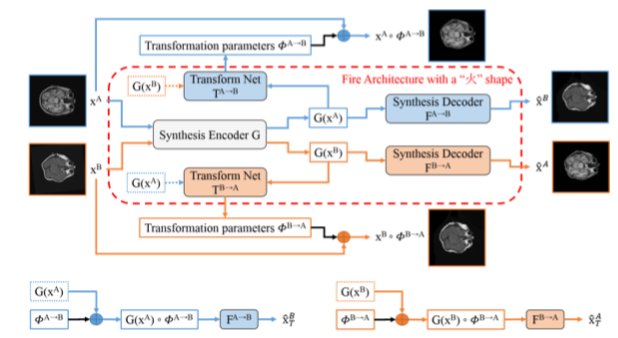

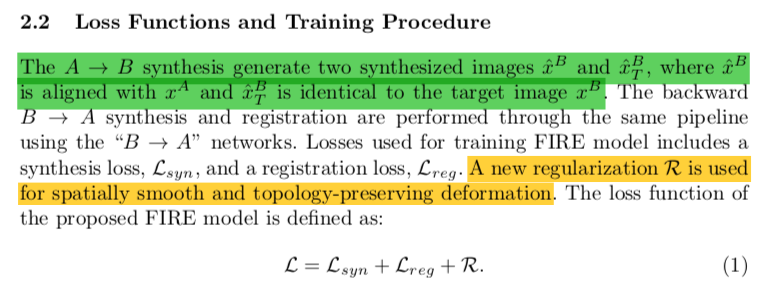

In [ ]:
class Fire_Model(nn.Module):
  def __init__(self):
    super(Fire_Model, self).__init__()
    self.encoder_A = Fire_Encoder(in_channel=1, start_channel=16)
    self.encoder_B = Fire_Encoder(in_channel=1, start_channel=16)

    self.decoder_A_B = Synthesizer_Decoder(start_channel=16)
    self.decoder_B_A = Synthesizer_Decoder(start_channel=16)

    self.transformer_A_B = Transformation_Deformable_Network(2)
    self.transformer_B_A = Transformation_Deformable_Network(2)

    self.spatial_transformer_deformable_A_B = SpatialTransformer(size=(32, 32, 32), is_affine=False)
    self.spatial_transformer_deformable_B_A = SpatialTransformer(size=(32, 32, 32), is_affine=False)

  def forward(self, XA, XB):
    GX_A = self.encoder_A(XA)
    GX_B = self.encoder_B(XB)

    # Transforming images

    # Get the deformation field
    phi_A_B = self.transformer_A_B(GX_A, GX_B)
    phi_B_A = self.transformer_B_A(GX_B, GX_A)

    #print("phi_A_B shape: {}".format(phi_A_B.shape) )
    #print("GX_A shape: {}".format(GX_A.shape))

    # Apply field to encoders
    print(phi_A_B.shape, GX_A.shape)
    GX_T_A = self.spatial_transformer_deformable_A_B(GX_A, phi_A_B )
    GX_T_B = self.spatial_transformer_deformable_B_A(GX_B, phi_B_A)

    # Registered images that actually deformed according to the other image through deformation field
    Xhat_T_A = self.decoder_A_B(GX_T_A)
    Xhat_T_B = self.decoder_B_A(GX_T_B)

    # Synthesis images that are identical to its counterpart without having deformation field applied
    Xhat_B = self.decoder_A_B(GX_A)
    Xhat_A = self.decoder_B_A(GX_B)

    return Xhat_T_A, Xhat_T_B, Xhat_A, Xhat_B


In [ ]:
firemodel = Fire_Model().to("cuda")

In [ ]:
xa = torch.randn(size=(2, 1, 128, 128, 128)).to("cuda")
xb = torch.randn(size=(2, 1, 128, 128, 128)).to("cuda")

In [ ]:
xhat_t_a, xhat_t_b, xhat_a, xhat_b = firemodel(xa, xb)

torch.Size([2, 16, 32, 32, 32])
torch.Size([2, 16, 32, 32, 32])
torch.Size([2, 16, 32, 32, 32])
torch.Size([2, 16, 32, 32, 32])
torch.Size([2, 16, 32, 32, 32])
torch.Size([2, 16, 32, 32, 32])
phi_A_B shape: torch.Size([2, 3, 32, 32, 32])
GX_A shape: torch.Size([2, 64, 32, 32, 32])
torch.Size([2, 3, 32, 32, 32]) torch.Size([2, 64, 32, 32, 32])


In [ ]:
del firemodel

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Thu Mar 18 13:56:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |  12512MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------